In [1]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import pickle

# debugging

In [78]:
nfile_data = [29716911.4994, 31254351.3332, 31924288.7483, 31548113.7203, 30918412.061]  # _gaps.txt; 2012, 2013, 2014, 2015, 2016
# 25wan, 30wan ????
debug1 = 0
debug2 = 558561
lifetime = 86400*365
energy_cut = 1
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_full_h5/data_2012_full.h5','r') as f:

    CUT_presel = (f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:] > energy_cut)
    CUT_ineff = np.ones(len(CUT_presel),dtype='bool')
    print(len(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    chi2_data_2012 = f.root.Collection.cols.chi2[:][CUT_presel & CUT_ineff][debug1:debug2]
    ndf_data_2012 = f.root.Collection.cols.NDF[:][CUT_presel & CUT_ineff][debug1:debug2]
    chi2_red_data_2012 = chi2_data_2012/ndf_data_2012
    PeakOverMedian_data_2012 = f.root.Collection.cols.PeakOverMedian[:][CUT_presel & CUT_ineff][debug1:debug2]
    zenith_data_2012 = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT_presel & CUT_ineff][debug1:debug2]
    truncated_muon_e_data_2012 = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT_presel & CUT_ineff][debug1:debug2]
    rejected_2_data_2012 = ((1 - f.root.IT_veto_flag_window_2.cols.value[:]).astype(bool))[CUT_presel & CUT_ineff][debug1:debug2]  # background (muon bundle) events!
    run_2012 = f.root.I3EventHeader.cols.Run[:][CUT_presel & CUT_ineff][debug1:debug2]
    weight_data_2012 = lifetime/nfile_data[0] * np.ones(len(chi2_red_data_2012))

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_full_h5/data_2013_full.h5','r') as f:

    CUT_presel = (f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:] > energy_cut)
    CUT_ineff = np.ones(len(CUT_presel),dtype='bool')
    
    chi2_data_2013 = f.root.Collection.cols.chi2[:][CUT_presel & CUT_ineff][debug1:debug2]
    ndf_data_2013 = f.root.Collection.cols.NDF[:][CUT_presel & CUT_ineff][debug1:debug2]
    chi2_red_data_2013 = chi2_data_2013/ndf_data_2013
    PeakOverMedian_data_2013 = f.root.Collection.cols.PeakOverMedian[:][CUT_presel & CUT_ineff][debug1:debug2]
    zenith_data_2013 = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT_presel & CUT_ineff][debug1:debug2]
    truncated_muon_e_data_2013 = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT_presel & CUT_ineff][debug1:debug2]
    rejected_2_data_2013 = ((1 - f.root.IT_veto_flag_window_2.cols.value[:]).astype(bool))[CUT_presel & CUT_ineff][debug1:debug2]  # background (muon bundle) events!

    weight_data_2013 = lifetime/nfile_data[1] * np.ones(len(chi2_red_data_2013))

558561


In [79]:
f = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_full_h5/data_2012_full.h5','r')


In [100]:
f.root.I3EventHeader.cols.Run[269950:275500]

array([120985, 120985, 120985, ..., 120985, 120985, 120985], dtype=uint32)

In [123]:
# abnormal run: 120985. So the burn sample is normal. 

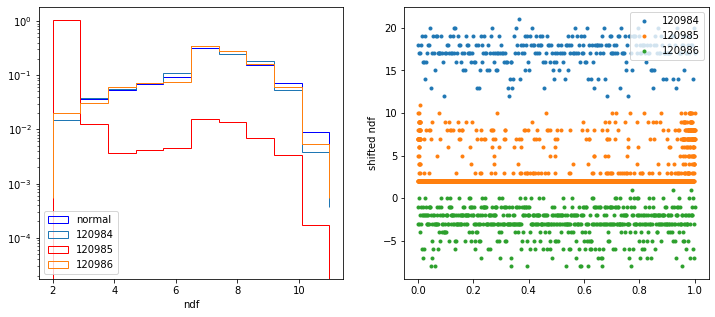

In [127]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(ndf_data_2013[:],bins=10,log=True,histtype='step',color='blue',density=True,label='normal')
plt.hist(ndf_data_2012[run_2012==120984],bins=10,log=True,histtype='step',density=True,label='120984')
plt.hist(ndf_data_2012[run_2012==120985],bins=10,log=True,histtype='step',color='red',density=True,label='120985')
plt.hist(ndf_data_2012[run_2012==120986],bins=10,log=True,histtype='step',density=True,label='120986')

plt.xlabel('ndf')
plt.legend()
plt.subplot(122)
plt.plot(np.linspace(0,1,len(ndf_data_2012[run_2012==120984])),ndf_data_2012[run_2012==120984]+10,'.',label='120984')
plt.plot(np.linspace(0,1,len(ndf_data_2012[run_2012==120985])),ndf_data_2012[run_2012==120985],'.',label='120985')
plt.plot(np.linspace(0,1,len(ndf_data_2012[run_2012==120986])),ndf_data_2012[run_2012==120986]-10,'.',label='120986')
plt.legend(loc='upper right')
plt.ylabel('shifted ndf')
# plt.savefig('/Users/yang/Desktop/debug.pdf')
plt.show()

# recalculating

In [207]:
data = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/0_sanity_check/debug_Run00120984.txt')
ndf_4 = data[:,1]
data = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/0_sanity_check/debug_Run00120985.txt')
ndf_5 = data[:,1]
data = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/0_sanity_check/debug_Run00120986.txt')
ndf_6 = data[:,1]

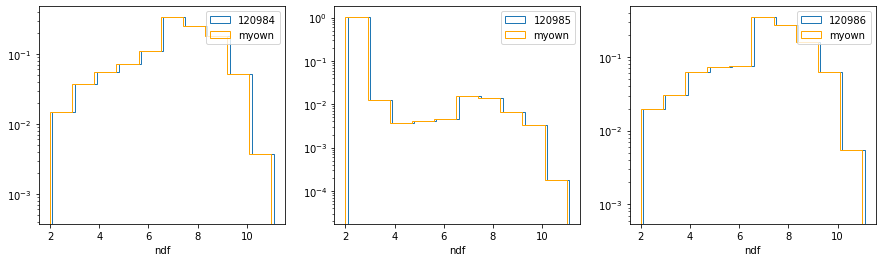

In [208]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.hist(ndf_data_2012[run_2012==120984]+0.1,bins=10,log=True,histtype='step',density=True,label='120984')
plt.hist(ndf_4,bins=10,log=True,histtype='step',density=True,label='myown',color='orange')
plt.legend()
plt.xlabel('ndf')
plt.subplot(132)
plt.hist(ndf_data_2012[run_2012==120985]+0.1,bins=10,log=True,histtype='step',density=True,label='120985')
plt.hist(ndf_5,bins=10,log=True,histtype='step',density=True,label='myown',color='orange')
plt.xlabel('ndf')
plt.legend()
plt.subplot(133)
plt.hist(ndf_data_2012[run_2012==120986]+0.1,bins=10,log=True,histtype='step',density=True,label='120986')
plt.hist(ndf_6,bins=10,log=True,histtype='step',density=True,label='myown',color='orange')
plt.xlabel('ndf')
plt.legend()
plt.show()

# ok, it's not in good run list!!